In [213]:
import requests
from bs4 import BeautifulSoup
from selenium.common.exceptions import NoSuchElementException, ElementClickInterceptedException
from selenium import webdriver

import pandas as pd

## Overview

In this section, we want to identify which companies can be approached for internships in data science. There are many ways that this question can be approached, but we decided to focus on two main features of companies: their ratings and salary for. These two features are chosen because of they can be obtained from a number of job search platform including Glassdoor, Workopoli, indeed among others.
* Salary as a feature was chosen because it tends to reflect how much responsibility a job entails and most often the company's size or resources. Data on Salary for data science related jobs is obtained from the workopolis platform.
* Ratings are also used because they reflect public opinion about the company. We are using glassdoor to get companies' ratings. For each company associated with a job posting, ratings on career opportunities, benefits, culture & values, senior management, work/life balance are included as well as the overall company ratings. We will look at all these ratings to score a company.



## Glassdoor and Ratings

As discussed above, we will be using Glassdoor to get ratings of different companies, which will later help in identifying which companies to choose. The following process will be used:
* Web scapping Glassdoor to get the ratings features and basic company information
* Visualize and analyse the data obtained above to make the final decision

### Web Scrapping

In this step, the following features are extracted from Glassdoor.

In [214]:
import time

options = webdriver.ChromeOptions()
driver = webdriver.Chrome(executable_path = "./chromedriver", options=options)

In [215]:
#ratings_df = pd.DataFrame()
types = ['Overall', 'Culture & Values', 'Work/Life Balance', 'Senior Management', 'Comp & Benefits', 'Career Opportunities']
def get_glassdoor_ratings():
    ratings_df = pd.DataFrame()
    
    pages = list(range(0,1000,20))

    for page in pages:
        url = "https://www.glassdoor.ca/Job/toronto-data-science-jobs-SRCH_IL.0,7_IC2281069_KO8,20_IP" + str(page) + ".htm"
        driver.get(url)

        jobs = driver.find_elements_by_class_name("jl")
        #job = job_buttons[0]
        for job in jobs:
            details = {}
            job.click()
            time.sleep(5)

            # get company name and job title
            try:
                company = driver.find_element_by_xpath('.//div[@class="employerName"]').text.split("\n")[0]
            except:
                company = None
                
            try:
                job_title = driver.find_element_by_xpath('.//div[contains(@class, "title")]').text
            except:
                job_title = None

            try:
                
                driver.find_element_by_xpath('.//div[@data-test="tab" and @data-tab-type="rating"]').click()
                overall_rating = driver.find_element_by_xpath('.//span[@class="avg"]').text

                #Get all other ratings
                soup = BeautifulSoup(driver.page_source, 'html.parser')

                rating_types = ['Overall']
                for rtype in soup.find_all(class_ = "ratingType"):
                    #text = rtype.text.lower()
                    #text = text.replace("&", "").replace(" ", "")

                    rating_types.append(rtype.text)

                ratings = [float(overall_rating)]
                for rating in soup.find_all(class_ = "ratingValue"):
                    rating = float(re.findall(r"[-+]?\d*\.\d+|\d+", rating.text)[0])
                    ratings.append(rating)

                details = dict(zip(types, ratings))
            except:
                details = dict(zip(rating_types, [None, None, None, None, None, None]))
                
            try:
                driver.find_element_by_xpath('.//div[@data-test="tab" and @data-tab-type="overview"]').click()
                industry = driver.find_element_by_xpath('.//div[@class="infoEntity"]//label[text()="Industry"]//following-sibling::*').text
            except:
                industry = None

            details['Industry'] = industry
            details['Company'] = company
            details['Title'] = job_title
            ratings_df = ratings_df.append(details, ignore_index=True)
    return ratings_df

In [216]:
#uncoment if new data is needed
#ratings_df = get_glassdoor_ratings()
#ratings_df.head()

#ratings_df = ratings_df[pd.notna(ratings_df['Overall'])]
#ratings_df.to_csv('./glassdoor_ratings.csv', index=True)

In [225]:
#Read in the already saved data
ratings_df = pd.read_csv('glassdoor_ratings.csv')
ratings_df.drop(['Unnamed: 0'], axis=1, inplace=True)
ratings_df.head()

,Career Opportunities,Comp & Benefits,Company,Culture & Values,Industry,Overall,Senior Management,Title,Work/Life Balance,Diversity & Inclusion
0,2.9,2.5,Spin Master Ltd,3.0,Consumer Products Manufacturing,3.0,2.2,"Senior Manager, Data Science",3.2,NaN
1,3.8,4.2,Ian Martin,4.4,Staffing & Outsourcing,4.2,4.3,Data Engineer - BNSJP00016223,4.6,NaN
2,3.3,3.6,Softchoice,4.1,IT Services,3.7,3.8,Customer Insights Program Manager,4.4,NaN
3,3.4,3.4,HUB International,3.7,Insurance Agencies & Brokerages,3.6,3.6,Data Analyst (Insurance),4.2,NaN
4,3.9,3.8,Enhance IT,4.0,NaN,4.1,4.0,Big Data Engineer,5.0,NaN


In [240]:
ratings_df.groupby(['Industry']).size()

Industry
Accounting                                  1
Advertising & Marketing                     7
Audiovisual                                 1
Banks & Credit Unions                       1
Biotech & Pharmaceuticals                   2
Cable, Internet & Telephone Providers       1
Colleges & Universities                     1
Computer Hardware & Software               10
Consumer Products Manufacturing             1
Education Training Services                 2
Energy                                      1
Enterprise Software & Network Solutions    10
Federal Agencies                            1
Health Care Services & Hospitals            3
IT Services                                 3
Insurance Agencies & Brokerages             2
Insurance Carriers                          2
Internet                                    6
Investment Banking & Asset Management       4
Membership Organizations                    1
Other Retail Stores                         1
Parking Lots & Garages   

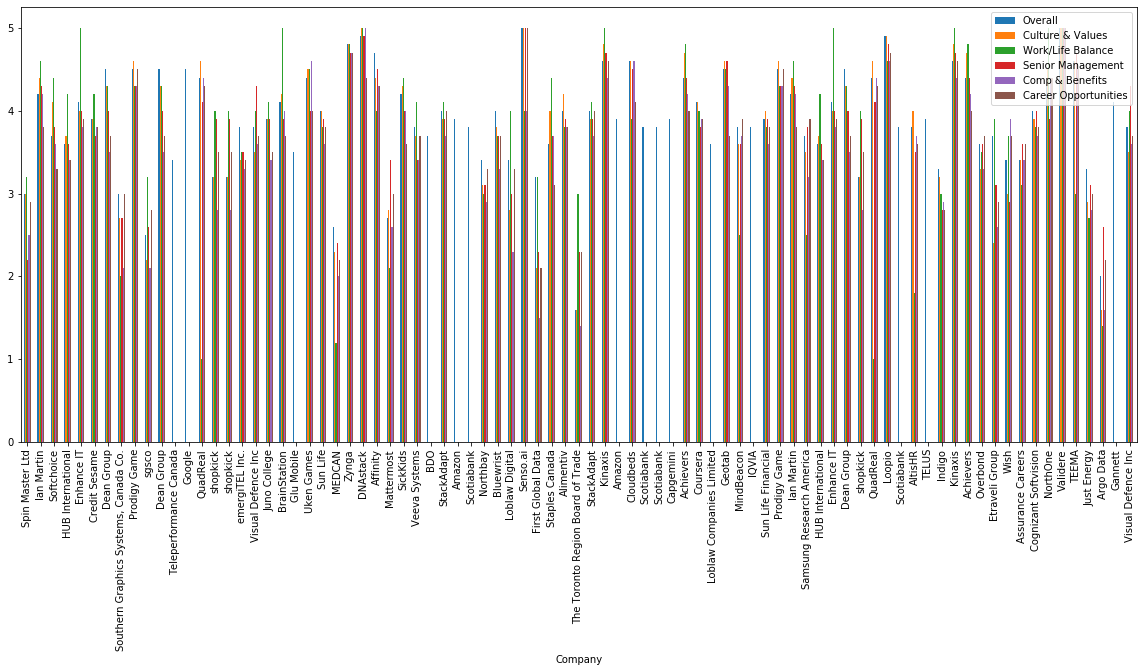

In [241]:
import matplotlib.pyplot as plt
%matplotlib inline

ratings_df.plot(x="Company", y=types, kind="bar", figsize=(20,8))
plt.show()

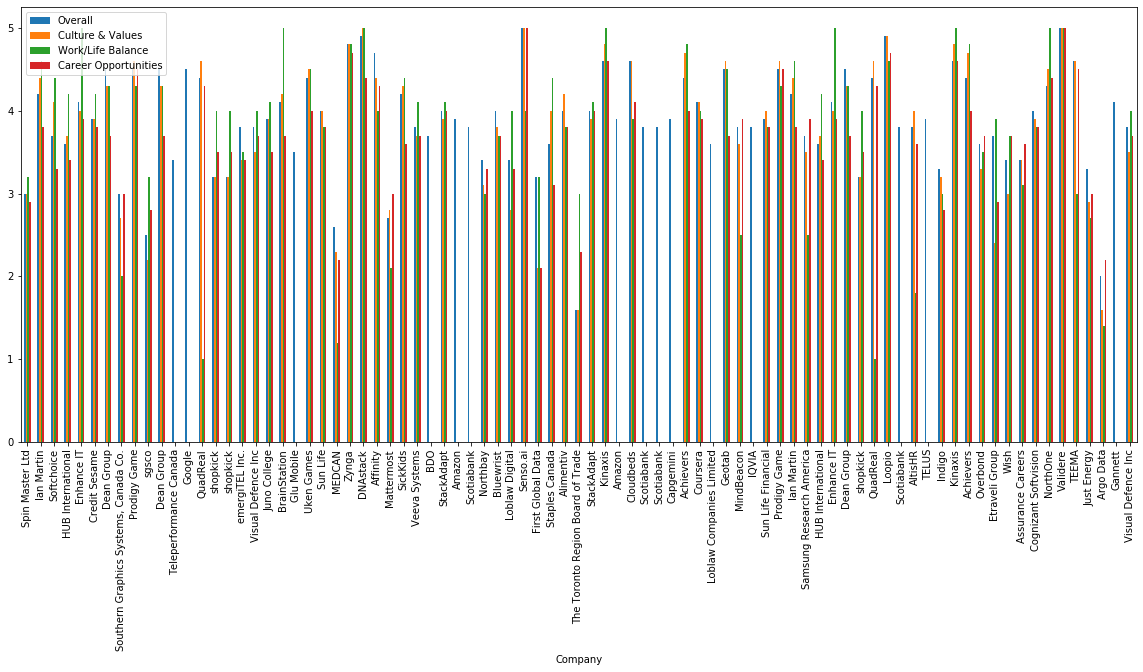

In [242]:
# View only the potentially important ratings
ratings_df.plot(x="Company", y=['Overall', 'Culture & Values', 'Work/Life Balance', 'Career Opportunities'], kind="bar", figsize=(20,8))
plt.show()

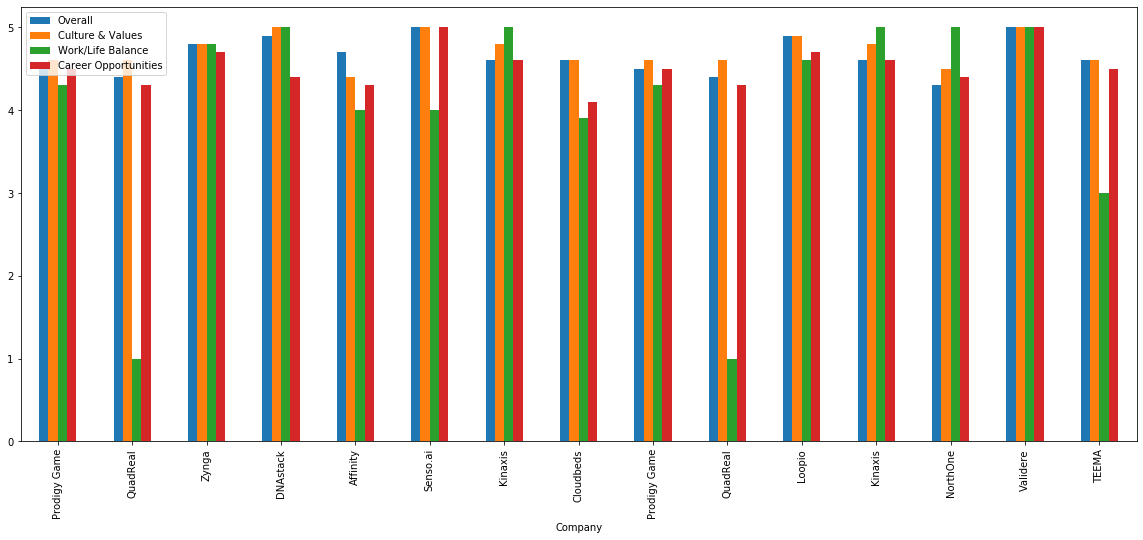

In [227]:
with_opportunities = ratings_df[ratings_df['Career Opportunities'] > 4]
with_opportunities.plot(x="Company", y=['Overall', 'Culture & Values', 'Work/Life Balance', 'Career Opportunities'], kind="bar", figsize=(20,8))
plt.show()

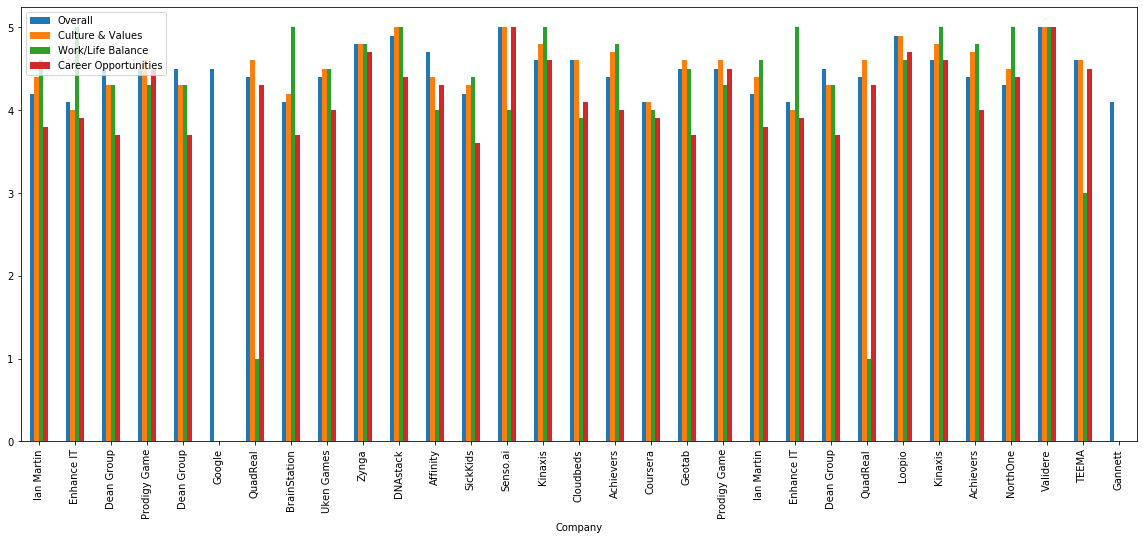

In [243]:
#Only companies with high overall rating
high_rating = ratings_df[ratings_df['Overall'] > 4]
high_rating.plot(x="Company", y=['Overall', 'Culture & Values', 'Work/Life Balance', 'Career Opportunities'], kind="bar", figsize=(20,8))
plt.show()

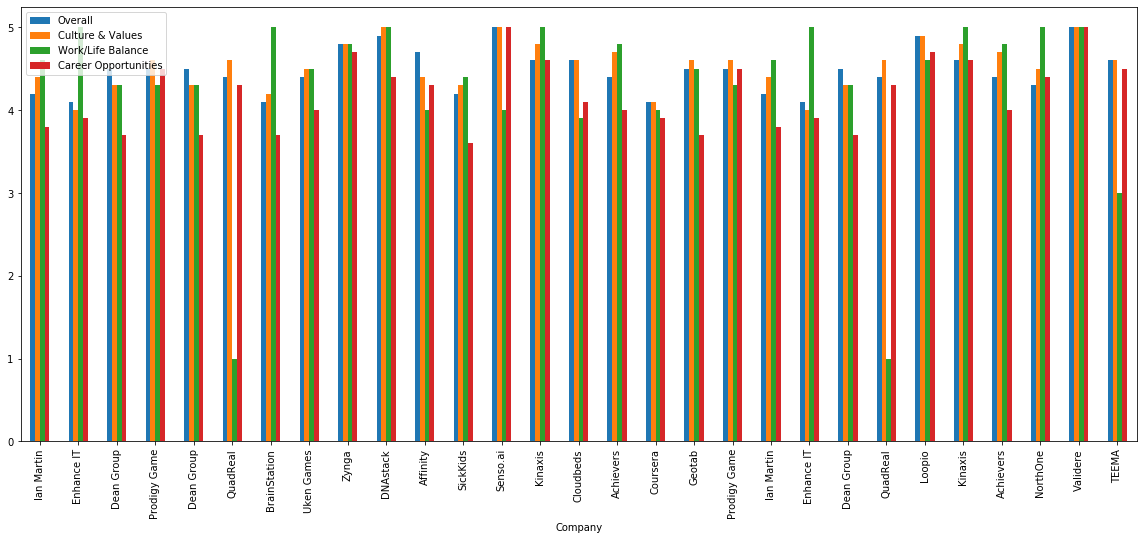

In [229]:
# Companies with high ratings and high career opportunities ratings (useful info for interns)
higher_rating = ratings_df[(ratings_df['Overall'] > 4) & (ratings_df['Career Opportunities'] > 3.5)]
higher_rating.plot(x="Company", y=['Overall', 'Culture & Values', 'Work/Life Balance', 'Career Opportunities'], kind="bar", figsize=(20,8))
plt.show()